In [1]:
import json
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, diags, load_npz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open("/content/drive/MyDrive/dedicated_WAM/data/gemma-2-2b_25-gemmascope-res-16k.json", "r") as f:
    description = json.load(f)

In [4]:
def load_sparse(folder_path, file_name):
    big_sparse = load_npz(f"{folder_path}{file_name}.npz")
    seq_lengths = np.load(f"{folder_path}{file_name}_seq_lengths.npy", allow_pickle=True).tolist()

    result = []
    idx = 0
    for L in seq_lengths:
        prompt_feats = big_sparse[idx: idx + L, :]
        result.append(prompt_feats)
        idx += L

    return np.array([sparse.max(axis=0).toarray().flatten() for sparse in result])

In [5]:
def load_model(model_name):
    folder_path = f"/content/drive/MyDrive/dedicated_WAM/results/Embeddings/Sparse_matrices/{model_name}-25k/"

    female_outputs = "female_sae_embeddings"
    male_outputs = "male_sae_embeddings"

    she_act = load_sparse(folder_path, female_outputs)
    he_act = load_sparse(folder_path, male_outputs)

    return {'she': she_act, 'he': he_act}

In [6]:
def conditional_activation(X, Y):
    """
    Compute the matrix P where P[i, j] = P(Y_i | X_j) = P(Y_i and X_j) / P(X_j)

    Parameters:
    - X: numpy array of shape (p, N) representing inputs.
    - Y: numpy array of shape (p, N) representing outputs.

    Returns:
    - P: numpy array of shape (N, N) containing the conditional probabilities.
    """

    # Convert to sparse boolean matrices
    X_active = csr_matrix(X != 0, dtype=np.int32)
    Y_active = csr_matrix(Y != 0, dtype=np.int32)

    # Compute co-occurrence counts = P(Y_i and X_j)
    co_occurrence = X_active.T.dot(Y_active)

    # Get the count for input features = P(X_j)
    counts = np.array(X_active.sum(axis=0)).ravel()

    # Create (1 / counts) avoiding division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reciprocal = np.where(counts > 0, 1.0 / counts, 0.0)

    # Scale each row of the co-occurrence matrix
    D = diags(reciprocal)
    scaled = D.dot(co_occurrence)
    P_sparse = scaled.transpose()  # P(Y_i and X_j) / P(X_j)
    P = P_sparse.toarray()

    return P

In [7]:
def calc_lift(X, Y):
    """
    Compute the matrix P where P[i, j] = P(Y_i | X_j) / P(X_j) = P(Y_i and X_j) / (P(X_j)^2)

    Parameters:
    - X: numpy array of shape (p, N) representing inputs.
    - Y: numpy array of shape (p, N) representing outputs.

    Returns:
    - P: numpy array of shape (N, N) containing the conditional probabilities.
    """

    # Convert to sparse boolean matrices
    X_active = csr_matrix(X != 0, dtype=np.int32)
    Y_active = csr_matrix(Y != 0, dtype=np.int32)

    # Compute co-occurrence counts = P(Y_i and X_j)
    co_occurrence = X_active.T.dot(Y_active)

    # Get the count for input features = P(X_j)
    counts = np.array(X_active.sum(axis=0)).ravel()

    # Create (1 / counts) avoiding division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reciprocal = np.where(counts > 0, 1.0 / (counts**2), 0.0)

    # Scale each row of the co-occurrence matrix
    D = diags(reciprocal)
    scaled = D.dot(co_occurrence)
    P_sparse = scaled.transpose()  # P(Y_i and X_j) / P(X_j)
    P = P_sparse.toarray()

    return P

In [8]:
input_folder = "/content/drive/MyDrive/dedicated_WAM/results/Embeddings/Sparse_matrices/Prompts-25k"

female_inputs = "/female_prompts_sae_embeddings"
male_inputs = "/male_prompts_sae_embeddings"

inputs = {'she': load_sparse(input_folder, female_inputs),
          'he': load_sparse(input_folder, male_inputs)}

In [9]:
deepseek = load_model("DeepSeek-V3")
mistral = load_model("Mistral-Nemo")
llama = load_model("Llama")

In [10]:
full_inputs = np.concatenate((inputs['she'], inputs['he']))

full_deepseek = np.concatenate((deepseek['she'], deepseek['he']))
full_mistral = np.concatenate((mistral['she'], mistral['he']))
full_llama = np.concatenate((llama['she'], llama['he']))

# Compute the conditional activation probabilities for each model.
conditional_probs_deepseek = conditional_activation(full_inputs, full_deepseek)
conditional_probs_mistral = conditional_activation(full_inputs, full_mistral)
conditional_probs_llama = conditional_activation(full_inputs, full_llama)

In [11]:
conditional_he = conditional_activation(inputs['he'], deepseek['he'])
conditional_she = conditional_activation(inputs['she'], deepseek['she'])

In [13]:
folder_path_clusters = '/content/drive/MyDrive/dedicated_WAM/features'

clusters = pd.read_csv(folder_path_clusters + "/clustered_features_sorted_k1000.csv")
cluster_dict = dict(zip(clusters['Feature'], clusters['cluster']))

cluster_clusters = pd.read_csv(folder_path_clusters + "/clustered_features_sorted_k30.csv")
cluster_clusters_dict = dict(zip(cluster_clusters['Feature'], cluster_clusters['cluster']))

cluster_dict = {feature: cluster_clusters_dict.get(cluster_dict.get(feature)) for feature in clusters['Feature']}

cluster_labels = pd.read_csv(folder_path_clusters + "/cluster_labels_fixed_30.csv")
cluster_labels_dict = dict(zip(cluster_labels['Cluster ID'], cluster_labels['Cluster Label']))

In [ ]:
# cluster_labels_dict[30] = 'She'
# cluster_labels_dict[31] = 'He'

In [ ]:
# cluster_dict[2550] = 31  # mentions of the pronoun "she"
# cluster_dict[13862] = 30 # the pronoun "he" and its variations

In [14]:
def cluster(array):
    array = pd.DataFrame(array)
    # Map DataFrame's index (rows) and columns to their clusters
    row_clusters = array.index.map(lambda x: cluster_dict.get(x, -1))
    col_clusters = array.columns.map(lambda x: cluster_dict.get(x, -1))

    # Group columns first: assign new column names based on clusters and compute the mean
    df_grouped_cols = array.copy()
    df_grouped_cols.columns = col_clusters
    grouped_cols = df_grouped_cols.groupby(df_grouped_cols.columns, axis=1).mean()

    # Then group rows: assign new index based on clusters and compute the mean
    grouped_cols.index = row_clusters
    result = grouped_cols.groupby(grouped_cols.index).mean()

    # Map cluster labels and remove unassigned clusters (-1)
    result.columns = result.columns.map(lambda x: cluster_labels_dict.get(x, x))
    result.index = result.index.map(lambda x: cluster_labels_dict.get(x, x))
    result.drop(index=-1, inplace=True)
    result.drop(columns=-1, inplace=True)

    return result

In [15]:
def cluster_by(array, row_ids, row_labels):
    array = pd.DataFrame(array)
    subset = array.loc[row_ids]
    col_cluster = subset.columns.to_series().map(lambda x: cluster_dict.get(x, -1))
    grouped = subset.groupby(col_cluster, axis=1).mean()
    grouped.columns = grouped.columns.map(lambda x: cluster_labels_dict.get(x, x))
    grouped.index = row_labels
    return grouped.drop(columns=-1).T

In [16]:
# For DeepSeek
clustered_deepseek = cluster_by(conditional_probs_deepseek, [2550, 13862], ['He', 'She'])
clustered_deepseek['Diff'] = clustered_deepseek['He'] - clustered_deepseek['She']

# For Mistral
clustered_mistral = cluster_by(conditional_probs_mistral, [2550, 13862], ['He', 'She'])
clustered_mistral['Diff'] = clustered_mistral['He'] - clustered_mistral['She']

# For Llama
clustered_llama = cluster_by(conditional_probs_llama, [2550, 13862], ['He', 'She'])
clustered_llama['Diff'] = clustered_llama['He'] - clustered_llama['She']

<ipython-input-15-018444f58080>:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = subset.groupby(col_cluster, axis=1).mean()
<ipython-input-15-018444f58080>:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = subset.groupby(col_cluster, axis=1).mean()
<ipython-input-15-018444f58080>:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = subset.groupby(col_cluster, axis=1).mean()


In [ ]:
#clustered = cluster(conditional_probs)
#clustered.drop(labels=['Community Health & Support', 'Food & Culinary Knowledge'], axis=0, inplace=True)
#clustered.drop(labels=['Community Health & Support', 'Food & Culinary Knowledge'], axis=1, inplace=True)

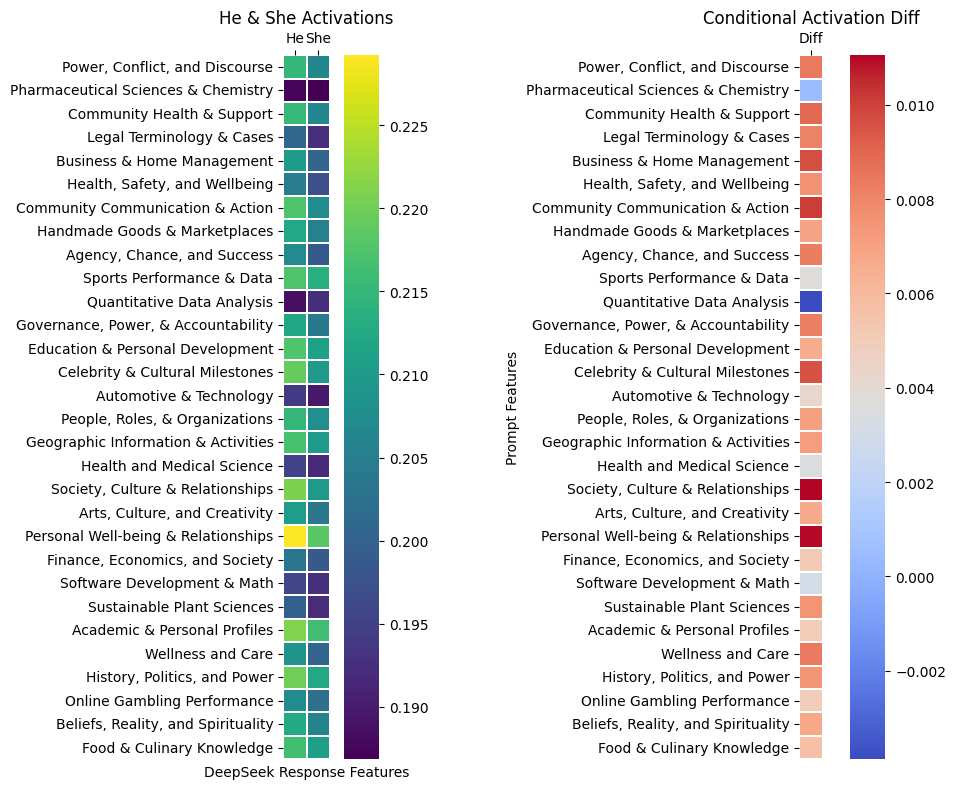

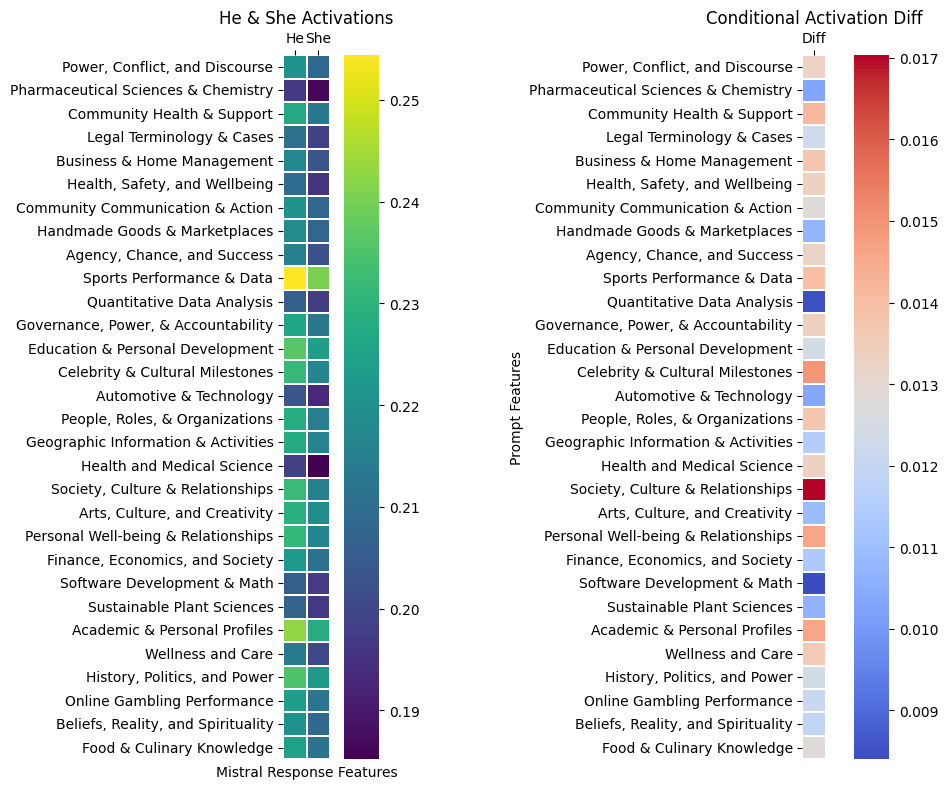

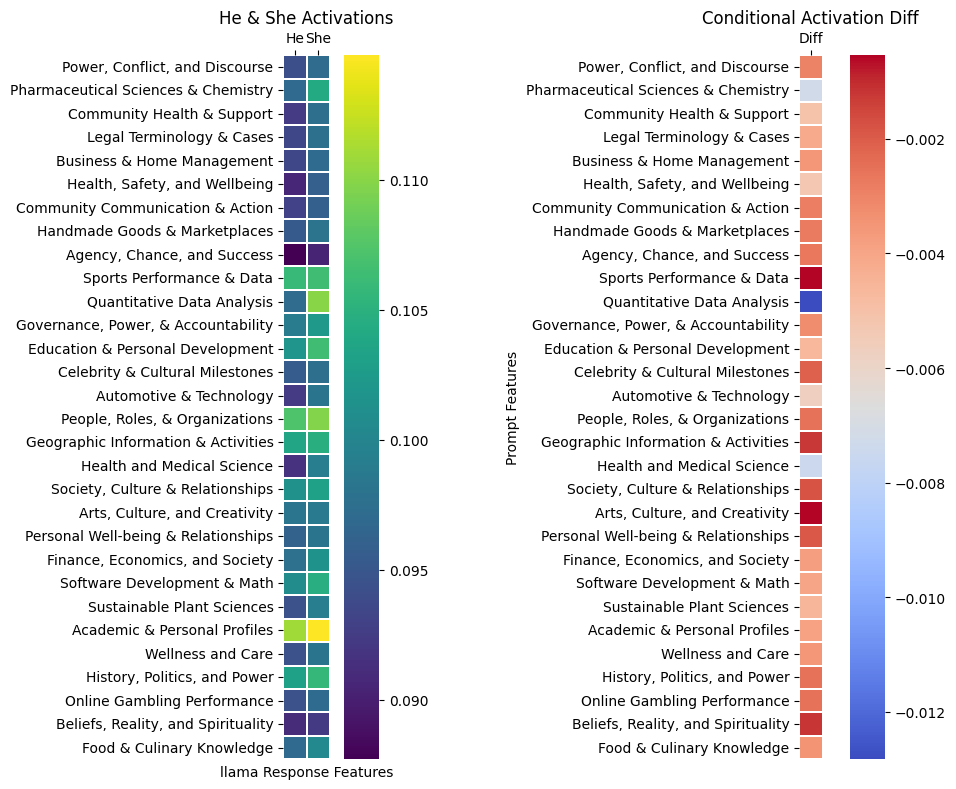

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 2]})
sns.heatmap(clustered_deepseek[['Diff']], ax=ax2, cmap="coolwarm", cbar=True, square=True, linewidths=0.1)
ax2.set_title("Conditional Activation Diff")
ax2.set_xlabel("")
ax2.set_ylabel("Prompt Features")
ax2.xaxis.tick_top()

sns.heatmap(clustered_deepseek[['He', 'She']], ax=ax1, cmap="viridis", cbar=True, square=True, linewidths=0.1)
ax1.set_title("He & She Activations")
ax1.set_xlabel("DeepSeek Response Features")
ax1.set_ylabel("")
ax1.xaxis.tick_top()

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 2]})
sns.heatmap(clustered_mistral[['Diff']], ax=ax2, cmap="coolwarm", cbar=True, square=True, linewidths=0.1)
ax2.set_title("Conditional Activation Diff")
ax2.set_xlabel("")
ax2.set_ylabel("Prompt Features")
ax2.xaxis.tick_top()

sns.heatmap(clustered_mistral[['He', 'She']], ax=ax1, cmap="viridis", cbar=True, square=True, linewidths=0.1)
ax1.set_title("He & She Activations")
ax1.set_xlabel("Mistral Response Features")
ax1.set_ylabel("")
ax1.xaxis.tick_top()

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 2]})
sns.heatmap(clustered_llama[['Diff']], ax=ax2, cmap="coolwarm", cbar=True, square=True, linewidths=0.1)
ax2.set_title("Conditional Activation Diff")
ax2.set_xlabel("")
ax2.set_ylabel("Prompt Features")
ax2.xaxis.tick_top()

sns.heatmap(clustered_llama[['He', 'She']], ax=ax1, cmap="viridis", cbar=True, square=True, linewidths=0.1)
ax1.set_title("He & She Activations")
ax1.set_xlabel("llama Response Features")
ax1.set_ylabel("")
ax1.xaxis.tick_top()

plt.tight_layout()
plt.show()

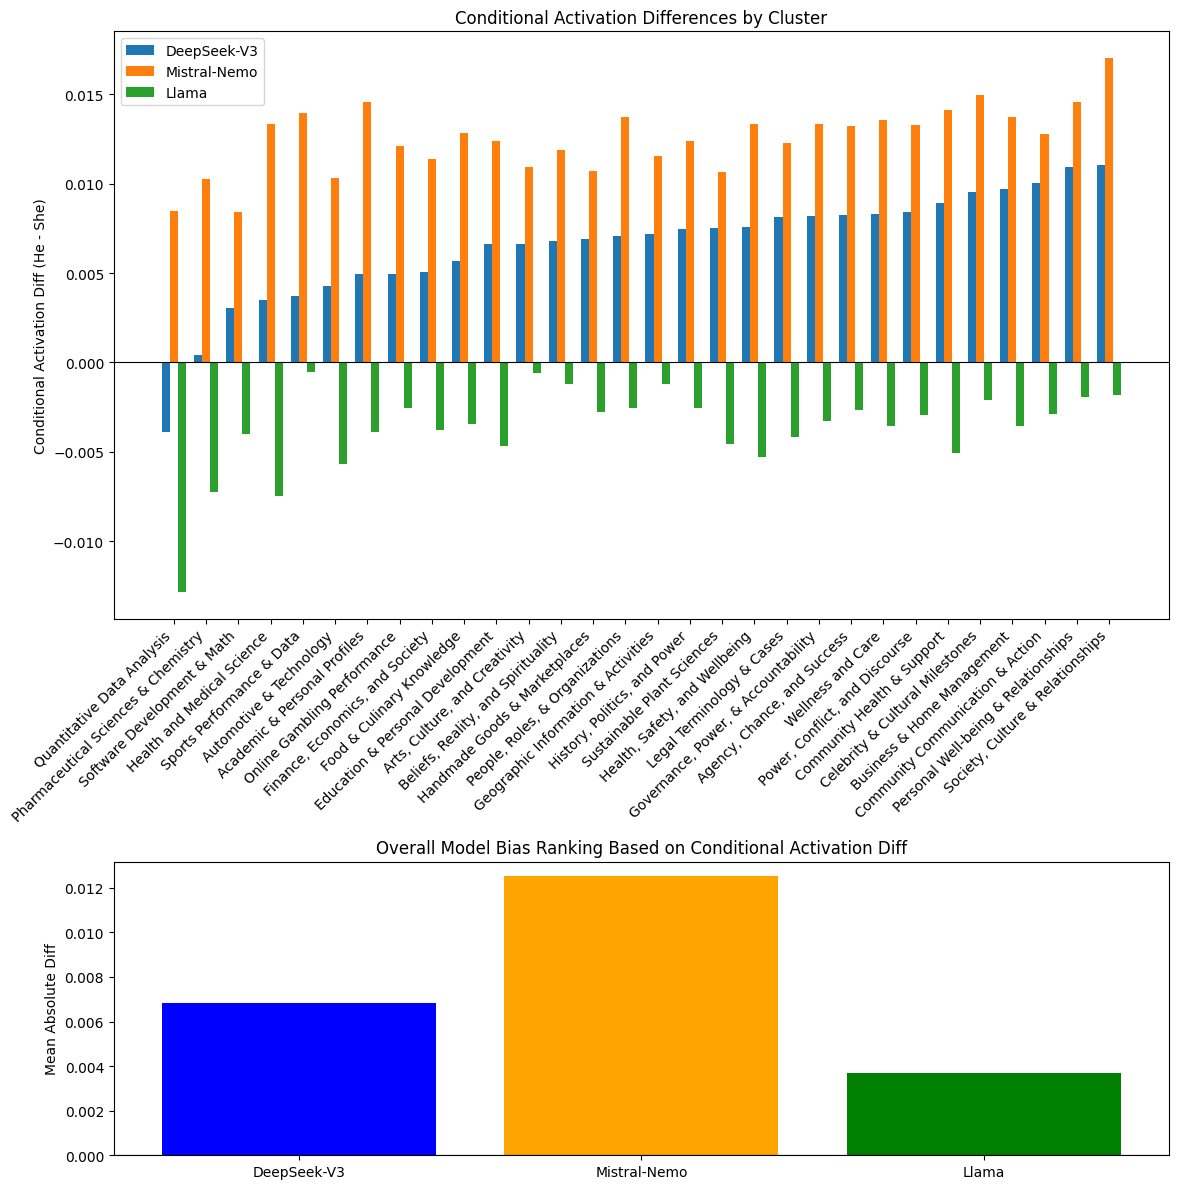

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --- Assume we already have these DataFrames from your analysis:
# clustered_deepseek, clustered_mistral, clustered_llama
# Each has an index corresponding to clusters (with semantic labels)
# and a column 'Diff' defined as: Diff = He - She

# For illustration, let's assume the DataFrames share the same cluster order.
# (If not, you may need to re-index or sort them so that the same clusters appear in the same order.)

# Create a single DataFrame that contains the Diff values for each model.
model_names = ['DeepSeek-V3', 'Mistral-Nemo', 'Llama']
diff_df = pd.DataFrame({
    'Cluster': clustered_deepseek.index,
    'DeepSeek-V3': clustered_deepseek['Diff'],
    'Mistral-Nemo': clustered_mistral['Diff'],
    'Llama': clustered_llama['Diff']
}).set_index('Cluster')

# Optionally, sort clusters by one model's bias (e.g., DeepSeek-V3) to ease comparison.
diff_df = diff_df.sort_values(by='DeepSeek-V3')

# --- Create a Multi-panel Figure
# We'll use two rows:
# Top panel: Grouped bar chart for the per-cluster conditional activation differences.
# Bottom panel: A summary bar chart ranking each model based on an overall metric (e.g. mean absolute Diff).

fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# *** Top Panel: Grouped Bar Chart by Cluster ***
width = 0.25
x = np.arange(len(diff_df.index))
ax_top.bar(x - width, diff_df['DeepSeek-V3'], width=width, label='DeepSeek-V3')
ax_top.bar(x, diff_df['Mistral-Nemo'], width=width, label='Mistral-Nemo')
ax_top.bar(x + width, diff_df['Llama'], width=width, label='Llama')

ax_top.axhline(0, color='black', linewidth=0.8)  # Vertical line at zero helps gauge the direction.
ax_top.set_ylabel('Conditional Activation Diff (He - She)')
ax_top.set_title('Conditional Activation Differences by Cluster')
ax_top.set_xticks(x)
ax_top.set_xticklabels(diff_df.index, rotation=45, ha='right')
ax_top.legend()

mean_abs_bias = {
    'DeepSeek-V3': np.mean(np.abs(clustered_deepseek['Diff'])),
    'Mistral-Nemo': np.mean(np.abs(clustered_mistral['Diff'])),
    'Llama': np.mean(np.abs(clustered_llama['Diff']))
}
models = list(mean_abs_bias.keys())
bias_values = list(mean_abs_bias.values())

ax_bottom.bar(models, bias_values, color=['blue', 'orange', 'green'])
ax_bottom.set_ylabel('Mean Absolute Diff')
ax_bottom.set_title('Overall Model Bias Ranking Based on Conditional Activation Diff')
ax_bottom.axhline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))
sorted_clusters = clustered[['Diff']].sort_values('Diff')
clusters_list = sorted_clusters.index.tolist()
diff_values = sorted_clusters['Diff'].values

y_positions = np.arange(len(clusters_list))
ax.axvline(x=0, color='black', linewidth=1)
ax.barh(y_positions, diff_values, color=['red' if val < 0 else 'blue' for val in diff_values])
ax.set_yticks(y_positions)
ax.set_yticklabels(clusters_list)
ax.invert_yaxis()  # Highest difference at the top
ax.set_xlabel('He - She Difference')
ax.set_title('Diverging Bar Chart of Gender Difference by Cluster')
plt.tight_layout()
plt.show()


In [ ]:
clustered_he = cluster(conditional_he)
# clustered_he.drop(labels=['Community Health & Support', 'Food & Culinary Knowledge'], axis=0, inplace=True)
# clustered_he.drop(labels=['Community Health & Support', 'Food & Culinary Knowledge'], axis=1, inplace=True)

clustered_she = cluster(conditional_she)
# clustered_she.drop(labels=['Community Health & Support', 'Food & Culinary Knowledge'], axis=0, inplace=True)
# clustered_she.drop(labels=['Community Health & Support', 'Food & Culinary Knowledge'], axis=1, inplace=True)

In [ ]:
lift_he = calc_lift(inputs['he'], deepseek['he'])
clustered_he = cluster(lift_he)

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(clustered_he, cmap="viridis", cbar=True, square=True, linewidths=0.1)
plt.title("Conditional Activation Matrix")
plt.xlabel("DeepSeek Response Features")
plt.ylabel("Prompt Features")
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(clustered_she - clustered_he, cmap="viridis", cbar=True, square=True, linewidths=0.1)
plt.title("Conditional Activation Matrix")
plt.xlabel("DeepSeek Response Features")
plt.ylabel("Prompt Features")
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(clustered_she, cmap="viridis", cbar=True, square=True, linewidths=0.1)
plt.title("Conditional Activation Matrix")
plt.xlabel("DeepSeek Response Features")
plt.ylabel("Prompt Features")
plt.show()